In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Dynamics of the COVID-19 infections - I
A research group from the Swiss Institute of Bioinformatics, lead by Richard Neher, developed a model to simulate the current Sars-CoV-2 Pandemic. The Model is based on a SEIR [1] framework, which was extended to account for the specific questions of interest in the current Pandemic. A special focus was set to asses the burden on the healthcare system and to model the capacity overflow on ICU units. Furthermore, the effect on different age groups can be assesed and the isolation of age groups can be modeled and the effect of seasonal forcing on the spread of infection can bes simulated [2]. The model was published as an interactive web application which freely accesible and lets the user explore fitted parameters based on obversational data and custom parameters [3]. 

[1] Kermack, W.O., McKendrick, A.G. Contributions to the mathematical theory of epidemics—I. Bltn Mathcal Biology 53, 33–55 (1991). https://doi.org/10.1007/BF02464423

[2] Neher R.A., Dyrdak R., Druelle V., Hodcroft EB., Albert J. Potential impact of seasonal forcing on a SARS-CoV-2 pandemic. Swiss Med Wkly. 150, w20224 (2020). https://doi.org/10.4414/smw.2020.20224

[3] COVID-19 Scenarios https://covid19-scenarios.org/


$N$ Population size<br>
$S(t)$ Susceptible people<br>
$E_1(t), E_2(t), E_3(t)$ Incubation states between infection and infectiousness<br>
$I(t)$ Infected individuals<br>
$R(t)$ Recovered patients<br>
$H(t)$ Hospitalized patients<br>
$C(t)$ Critical patients in ICU<br>
$O(t)$ Critical patients which can't go to ICU because of ICU overflow<br>
$D(t)$ Fatalaties due to infection<br>

$t_i$ average time between onset of sickness and recovery / death<br>
$t_l$ latency time between infection and infectiousness<br>
$R_0$ Average number of transmissions during the course of infection<br><br>

$m_a$ The fraction of cases, which are asymptotic or mild<br>
$c_a$ The fraction of severe cases that turn critical<br>
$f_a$ the fraction of critical cases that end fatal<br>

$$
\begin{align*}
    \frac{dS(t)}{dt} &= -\beta S(t) I(t) N^{-1}\\
    \frac{dE_1(t)}{dt} &= \beta S(t) I(t) N^{-1} - 3 E_1(t) t_l^{-1}\\
    \frac{dE_2(t)}{dt} &= 3 E_1(t) t_l^{-1} - 3 E_2(t) t_l^{-1}\\
    \frac{dE_3(t)}{dt} &= 3 E_2(t) t_l^{-1} - 3 E_3(t) t_l^{-1}\\
    \frac{dI(t)}{dt} &= 3 E_3(t) t_l^{-1} - I(t) t_i^{-1} \\
    \frac{dH(t)}{dt} &= (1-m_a) I(t)t_i^{-1}  + (1-f_a) C(t)t_c^{-1} - H(t)t_h^{-1}\\
    \frac{dC(t)}{dt} &= c_a H(t)t_h^{-1} - C(t)t_c^{-1}\\
    \frac{dR(t)}{dt} &= m_aI(t) t_i^{-1} + (1-c_a)H(t)t_h^{-1} \\
    \frac{dD(t)}{dt} &= f_aC(t)t_c^{-1}
\end{align*}
$$

<br>
$\beta_a(t)$ Seasonal infection rate. An infectious Person transmits the virus to $\beta_a(t)t_i$ healthy persons on average over the course of the infection.<br><br>
$\beta_a(t) = R_0 \zeta_{\alpha} M_a(t)(1+\epsilon \cos(2\pi(t-t_{max})/365))t_i^{-1}$

$t_{max} = 15$<br>
$\epsilon = 0.1$


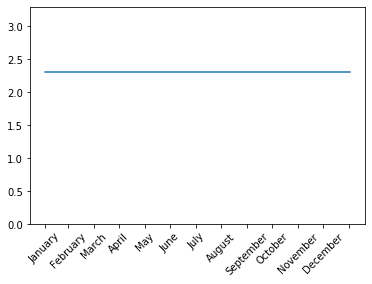

In [52]:
def beta(t,cm):
    zeta = 1
    M = 1
    epsilon = 0.0
    t_max = 15
    t_i = 5
    R_0 = 2.3
    R = R_0 * zeta * (1+epsilon*np.cos(2*np.pi*(t-t_max)/365))
    for m in cm:
        effect = np.where(np.logical_and(m["time"][0] < t, m["time"][1] > t))
        R[effect] *= (1 - m["reduction"][0])
    return R/t_i
    
t = np.linspace(1,365,365)

cm = [{"time": [30,280],
         "reduction": [0.30]},
     {"time": [50,290],
         "reduction": [0.40]}]

cm0 = []

R_0 = beta(t,cm0)*5
plt.plot(t,R_0)
plt.ylim((0,max(R_0)+1))
plt.xticks([0, 28, 59, 89, 120, 150, 181, 211, 242, 272, 303, 333,364], 
           ["January", 'February', "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], rotation=45)
plt.show()

In [106]:
def system(v,t):
    N = 1000
    tl = 3
    ti = 5
    cm_0 = []
    beta = beta(t,cm0)
    
    S, E1, E2, E3, I, R = v
    dvdt = [
        -beta*S*I/N, 
        beta*S*I/N - 3*E1/tl,
        3*E1/tl - 3*E2/tl,
        3*E2/tl - 3*E3/tl,
        3*E3/tl - I/ti,
        I/ti]
    return dvdt

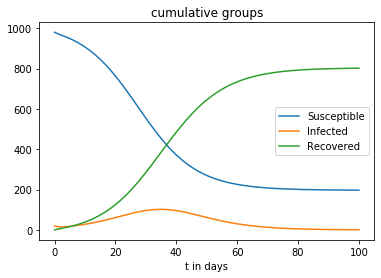

In [107]:
t = np.linspace(0,100,200)

v0 = [980,0,0,0,20,0]

solution = odeint(system, v0, t)

plt.plot(t,solution[:,0], label=r"Susceptible")
plt.plot(t,solution[:,4], label=r"Infected")
plt.plot(t,solution[:,5], label=r"Recovered")

plt.title("cumulative groups")
plt.xlabel("t in days")
plt.legend(loc='best')